# Intro to TensorFlow

The following is a small intro to how computational frameworks (theano, tensorflow) work in general.

### The MNIST dataset

It's just a set of 28 x 28 pixels of hand-written digits (greyscale) with labels which digit is on the picture.

In [24]:
# first we need some data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Let's load a minibatch of 100

We'll provide such mini-batches to our model during training to show it what it should learn.

In [25]:
batch_samples, batch_labels = mnist.train.next_batch(100)

In [26]:
batch_samples.shape

(100, 784)

In [8]:
batch_labels.shape

(100, 10)

### Now let's check an actual image:

Images are represented as a vector of number values, corresponding to the color intensity. Any sort of data can be represented as **numbers**, i.e. **vectors**. 

This means you can think of any sort of object as a point in a very high-dimensional space. Example: if your object is characterized by **(age, height, income)**, it's a point in 3D space. Our images above are points in 784-dim space.

In [22]:
image = batch_samples[0]
image

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

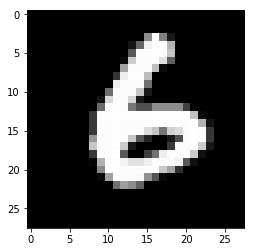

In [23]:
image = image.reshape((28, 28))
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(image, cmap='gray')

### Let's check what a label is

When we do classification, we use 1-hot encodings to represent the labels for multiple classes. Example, if there are 5 different classes and a point is in class 4:

```
[0, 0, 0, 1, 0]
```

Is the one-hot encoding of this class-membership. 

We use 1-hot encodings because if we just used numbers: 1 for class 1, 2 for class 2, etc... then the network would understand that class 4 is *"4 times bigger"* than class 1, which makes no sense and will lead the network in the wrong direction.

In [28]:
label = batch_labels[0]
label

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

## Now let's classify those digits in TensorFlow

Tensorflow is a computational framework, it let's us define mathematical expressions (i.e. formulas) and execute them on some inputs (distributed on GPUs even).

It also provides automatic gradient computations (differentiation of the formulas).

The formulas are first defined **symbolically**, as a template, and then used on actual data. Just like one does in math: you have a function with some parameters and inputs (the symbolic variables) and when you evaluate the function you plug in real values into those.


### First, let us construct our mapping from data to labels

In [36]:
import tensorflow as tf

# define a symbolic variable for the image input
# None is special syntax in most deep learning frameworks,
# it means this dimension might vary (it's the batch size)
x = tf.placeholder(dtype=tf.float32, 
                   shape=[None, 784])

# define symbolic variables for the parameters of our function
# tf.Variables are like function parameters, they are not the 
# arguments of the function, they define what the function
W = tf.Variable(tf.zeros(shape=[784, 10]))
b = tf.Variable(tf.zeros(shape=[10]))

# Now we will construct our function expression:
#
# Wx + b
#
# It's a linear transformation of the input
preds = tf.matmul(x, W) + b

# We now have transformed x to a 10-dim. vector,
# but we want to interpret each output as the probability
# of each of the 10 classes: and discrete probabilities sum up to 1.
# So we apply a softmax() to make this happen:
preds = tf.nn.softmax(preds)

### Now let's define our loss (what we need to optimize)

The loss for multi-class classification is the [categorical cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy).

When we define prediction & classification losses, we always need the true labels (ground truths) to *"compare"* against:

In [39]:
# this is now an argument (input) of the cost function,
# and not a parameter - hence tf.placeholder
targets = tf.placeholder(dtype=tf.float32, shape=[None, 10])

# now we define the cross_entropy formula
temp = - targets * tf.log(preds)

# but we need to sum over axis 1 (0 index),
# that's the 10-dim axis
temp = tf.reduce_sum(temp, reduction_indices=[1])

# and then take the mean over all samples in the batch
cross_entropy_loss = tf.reduce_mean(temp)

### Now we need to optimize the loss (minimize it)

We use a gradient descent method and gradually step down the loss surface until we reach a local minimum.

```
params = params - learning_rate * gradient
```

In [44]:
# we define our optimization method
# it will automatically do the derivatives for us
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)

# and then we take the update step:
#
# params = params - learning_rate * gradient
#
# from it
# NOTE: this is still a symbolic !!
update_step = optimizer.minimize(loss=cross_entropy_loss,
                                var_list=[W, b])

### Finally, let's do the actual optimization

Now we get to plug in real data in the above template, everything so far has been just (symbolic) declaration of what we would want to do.

In [46]:
# we need a session to actually run expressions
sess = tf.InteractiveSession()

# we initialize all global variables
# those are W and b in this case
tf.global_variables_initializer().run()

# and now we do 1000 optimizations
for _ in range(1000):
    batch_samples, batch_labels = mnist.train.next_batch(100)
    
    # we run the update_step from above, feeding in actual values
    # for x and targets
    sess.run(update_step, feed_dict={x: batch_samples,
                                    targets: batch_labels})

### Let's see how our model performs

In [50]:
# we define a symbolic expression to tell if a prediction is
# correct or not

# we need the argmax because preds is between 0 and 1, not
# only 0 and 1
correct_prediction = tf.equal(tf.argmax(preds,1), tf.argmax(targets,1))

# accuracy is the percentage of correct predictions over all
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# and now we execute the above symbolic expression on the actual data
# NOTE: we use a test set to check the accuracy, which the model has not
# seen before
sess.run(accuracy, feed_dict={x: mnist.test.images, 
                            targets: mnist.test.labels})

0.91659999

### ~ 92 % accurate predictions with a simple logistic regression, not too shabby :)